In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'kernel_sufficient_dimension_reduction'
seed = 42

In [2]:
import numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/kernel_sufficient_dimension_reduction'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
# specify dimension of X,Z
x_dim = 2
z_dim = 1
y_dim = 1 # code will assume this

In [5]:
# specify data distributions

# p_x
#p_x = scipy.stats.multivariate_normal(mean=np.zeros(shape=x_dim))
#p_x = scipy.stats.uniform(loc=np.zeros(shape=x_dim)
#p_x_pdf = p_x.pdf
p_x_sample = lambda : np.random.uniform(size=x_dim)
#p_x_sample = lambda : np.array(np.random.uniform(size=x_dim)<0.5,dtype=int)
#p_x_sample = lambda : np.zeros(shape=x_dim)

# W
#W = ortho(np.array([[1.,0.]]).T)
P = kernels.ortho(np.random.normal(size=(x_dim,z_dim)))
print 'P:', P

# p_y_given_z
f_z = lambda z: 1*np.ones(z_dim).dot(z)
y_var = 0.002
p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
#p_y_given_z_pdf = lambda y,z: p_y_noise.pdf(y-z)
p_y_given_z_sample = lambda z: f_z(z) + p_y_noise_sample()
#p_y_given_z_sample = lambda z: z
def mix():
    if np.random.uniform()>0.3:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*10.,cov=np.eye(y_dim)*y_var).rvs()
    else:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*-10.,cov=np.eye(y_dim)*y_var).rvs()
#p_y_given_z_sample = lambda z: f_z(z) + mix()

P: [[ 0.96337365]
 [-0.26816265]]


In [6]:
# specify number of data to generate
num_data = 50

In [7]:
# generate data
xs = np.array([p_x_sample() for i in xrange(num_data)])
zs = xs.dot(P)
ys = np.array([p_y_given_z_sample(z) for z in zs])

In [8]:
# define generic function plotter
def scatter(xs, ys, plot_dim=0):
    xs, ys = np.array(xs), np.array(ys)
    fig, ax = plt.subplots()
    plot_xs = xs if len(xs.shape)==1 else xs[:,plot_dim]
    ax.scatter(plot_xs, ys)
    basic.display_fig_inline(fig)
    
def scatter_3d(xs, ys, zs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs,s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    basic.display_fig_inline(fig)

In [9]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
plot_zs = zs
P_z = np.zeros((z_dim,1))
P_z[0] = 1.
plot_1d_zs = plot_zs.dot(P_z)
plot_ys = ys
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


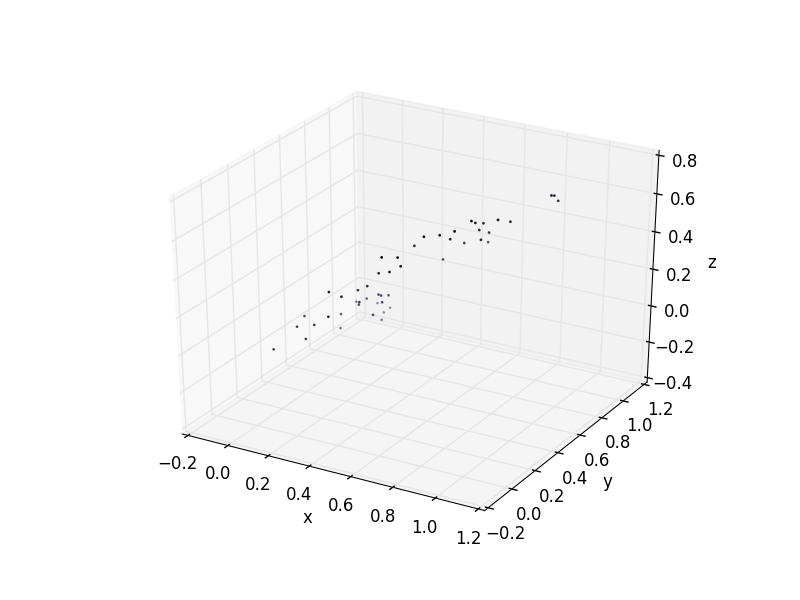

In [10]:
# plot data, 3d
scatter_3d(xs[:,xs_plot_dim_1],xs[:,xs_plot_dim_2],ys)

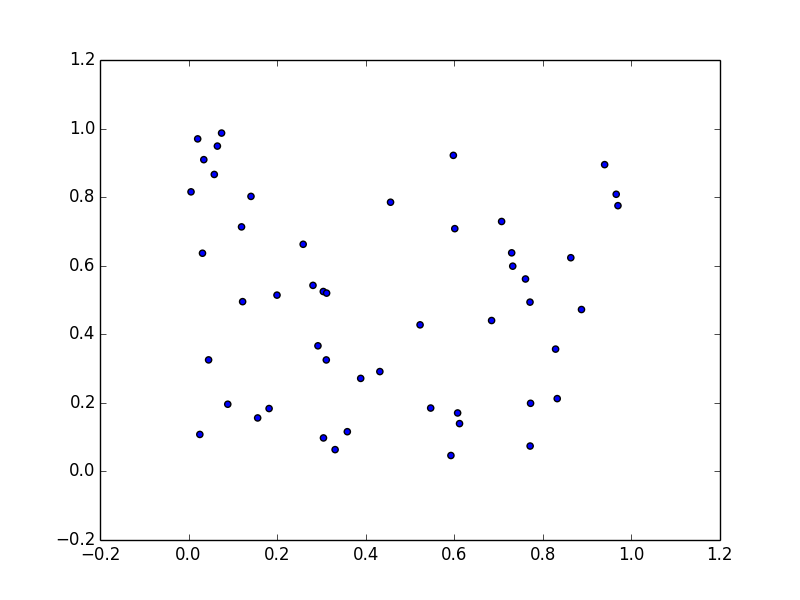

In [11]:
# plot xs, 2d
scatter(xs[:,xs_plot_dim_1],xs[:,xs_plot_dim_2])

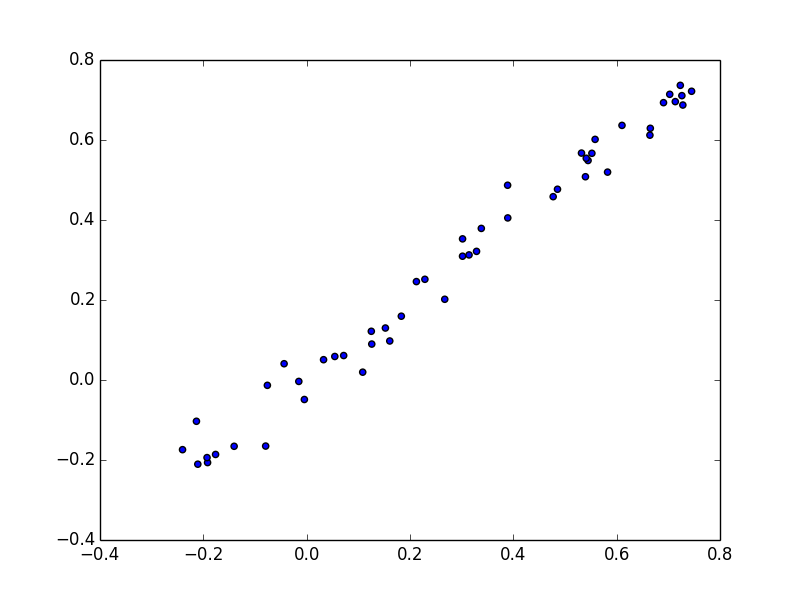

In [12]:
# plot data, 2d
scatter(plot_1d_zs,ys)

In [13]:
# define 
sigma = 1.
get_K = functools.partial(kernels.get_gaussian_K, sigma)
eps = 0.1
the_get_trace_from_P = functools.partial(kernels.get_trace_from_P, xs, ys, get_K, eps)

In [14]:
# for true zs, calculate objective fxn
true_zs_obj_val = the_get_trace_from_P(P)
print 'true_zs_obj_val', true_zs_obj_val

true_zs_obj_val 0.606974912256


trial 0
rand_P: [[-0.98096982]
 [ 0.19416029]]
dot with true_P: [[-0.94504047  0.26305947]
 [ 0.18704891 -0.05206654]]
rand_zs_obj_val: 0.850578782462


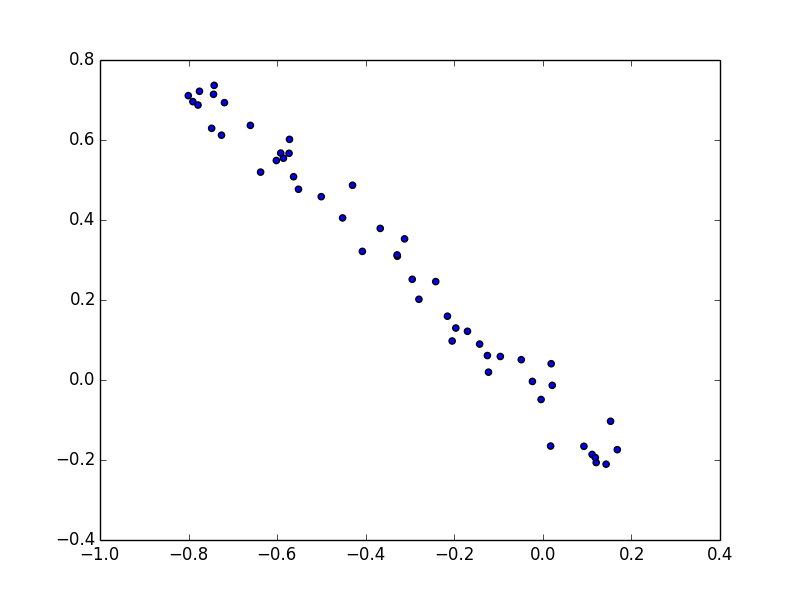

trial 1
rand_P: [[ 0.34479074]
 [-0.93867958]]
dot with true_P: [[ 0.33216231 -0.09246   ]
 [-0.90429917  0.2517188 ]]
rand_zs_obj_val: 0.85523015601


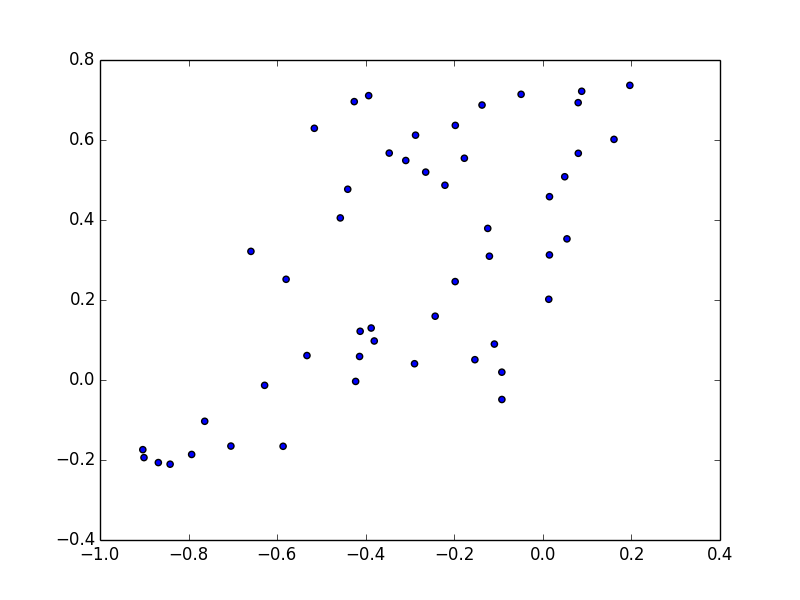

trial 2
rand_P: [[ 0.0441721 ]
 [-0.99902394]]
dot with true_P: [[ 0.04255423 -0.01184531]
 [-0.96243334  0.26790091]]
rand_zs_obj_val: 0.86790253358


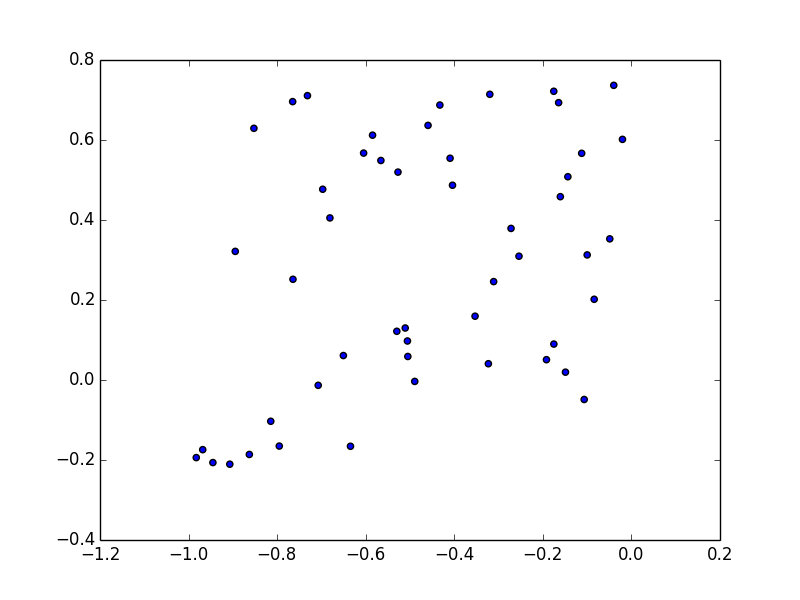

trial 3
rand_P: [[ 0.40718459]
 [-0.91334589]]
dot with true_P: [[ 0.3922709  -0.1091917 ]
 [-0.87989336  0.24492526]]
rand_zs_obj_val: 0.843591220761


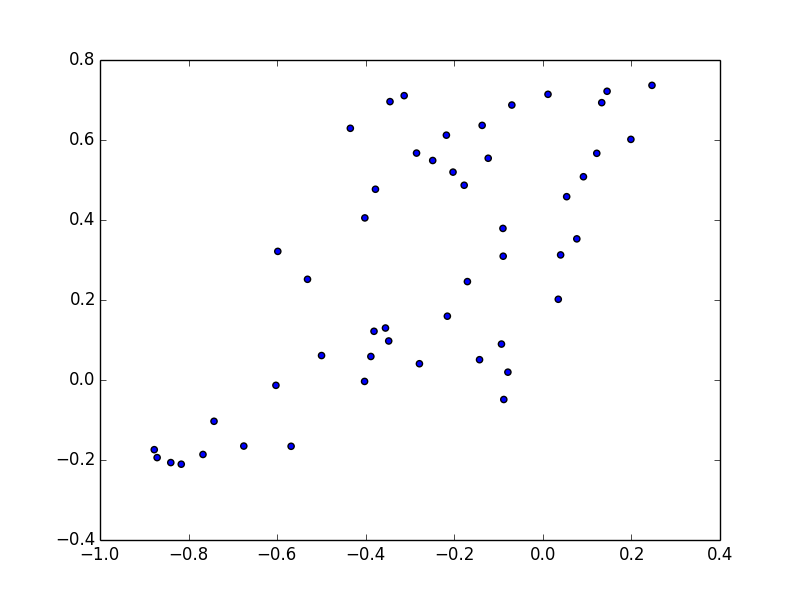

trial 4
rand_P: [[ 0.86006156]
 [-0.51019026]]
dot with true_P: [[ 0.82856065 -0.23063639]
 [-0.49150386  0.13681397]]
rand_zs_obj_val: 0.641380912488


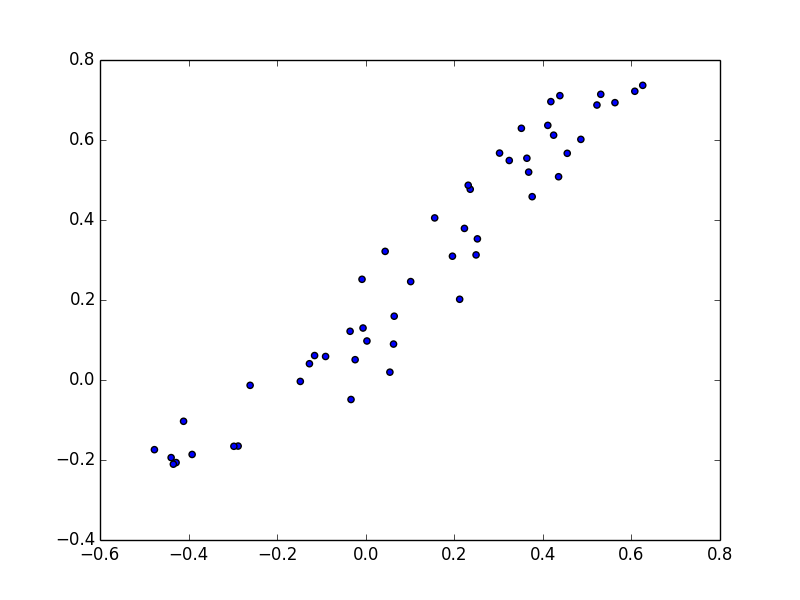

trial 5
rand_P: [[ 0.76948715]
 [-0.63866229]]
dot with true_P: [[ 0.74130365 -0.20634772]
 [-0.61527043  0.17126537]]
rand_zs_obj_val: 0.687951092035


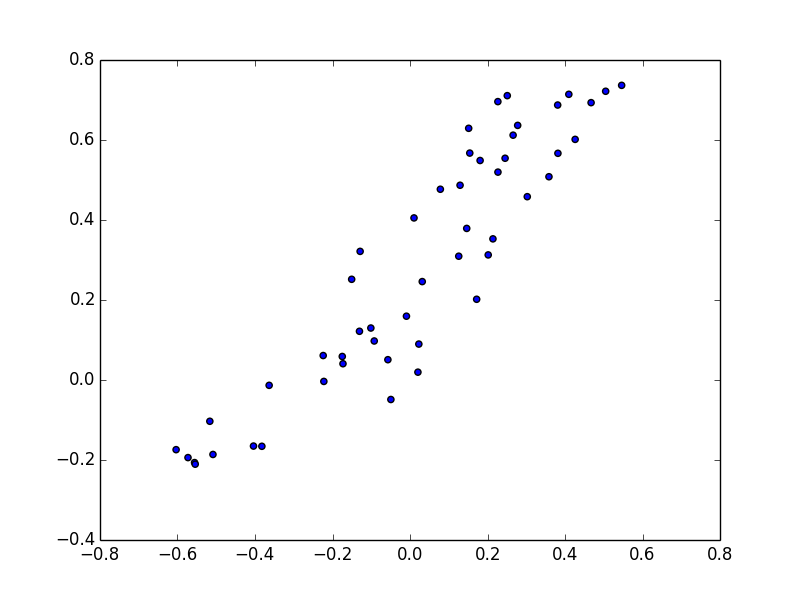

trial 6
rand_P: [[-0.38029084]
 [-0.92486695]]
dot with true_P: [[-0.36636218  0.1019798 ]
 [-0.89099245  0.24801477]]
rand_zs_obj_val: 0.834747906


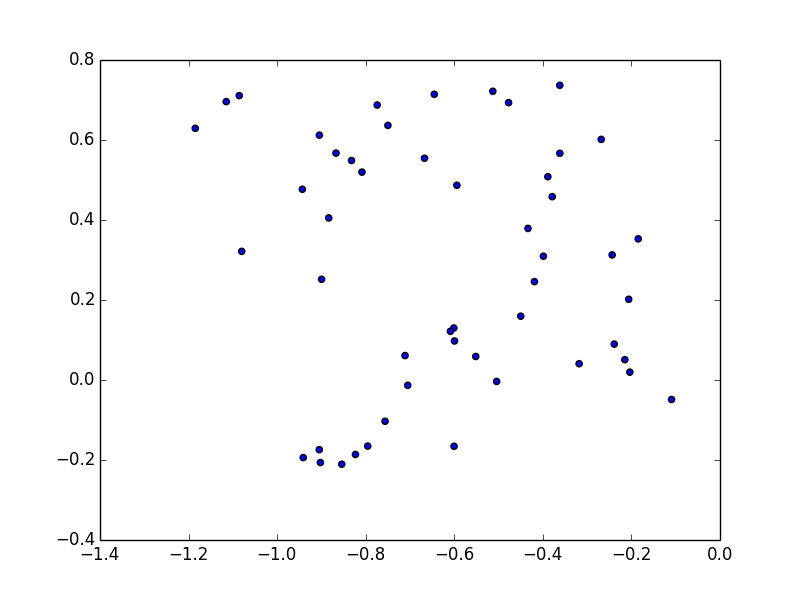

trial 7
rand_P: [[ 0.74755447]
 [ 0.66420051]]
dot with true_P: [[ 0.72017428 -0.20046619]
 [ 0.63987327 -0.17811377]]
rand_zs_obj_val: 0.747290289439


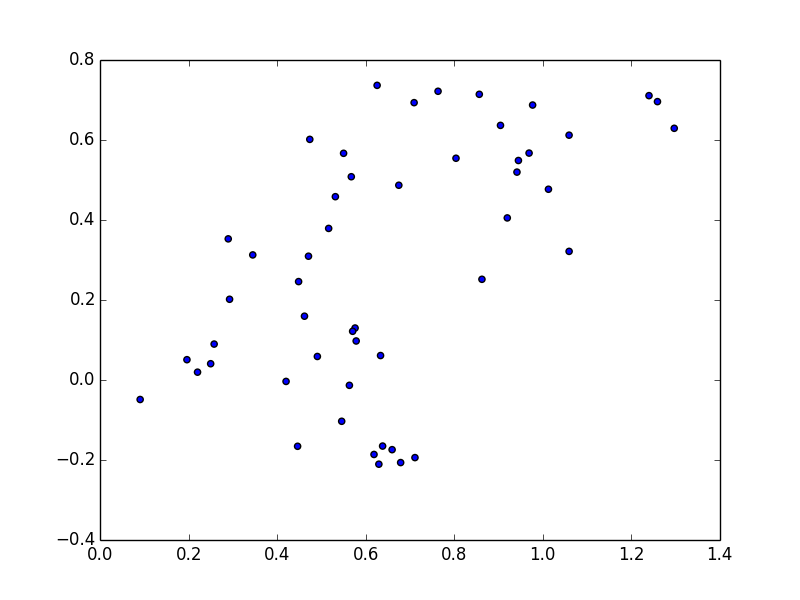

trial 8
rand_P: [[-0.8342519 ]
 [ 0.55138351]]
dot with true_P: [[-0.8036963   0.2237152 ]
 [ 0.53118834 -0.14786046]]
rand_zs_obj_val: 1.01893401973


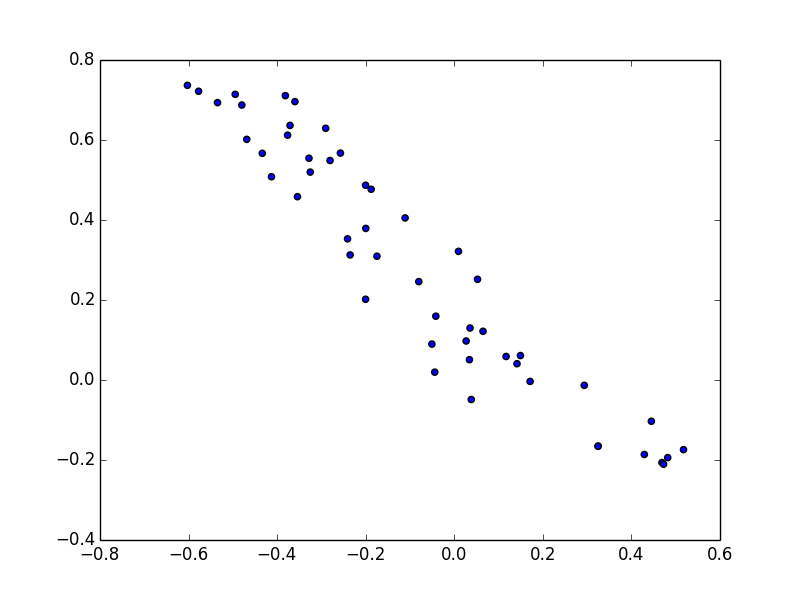

trial 9
rand_P: [[ 0.98519511]
 [ 0.17143683]]
dot with true_P: [[ 0.94911101 -0.26419253]
 [ 0.16515773 -0.04597296]]
rand_zs_obj_val: 0.640986217751


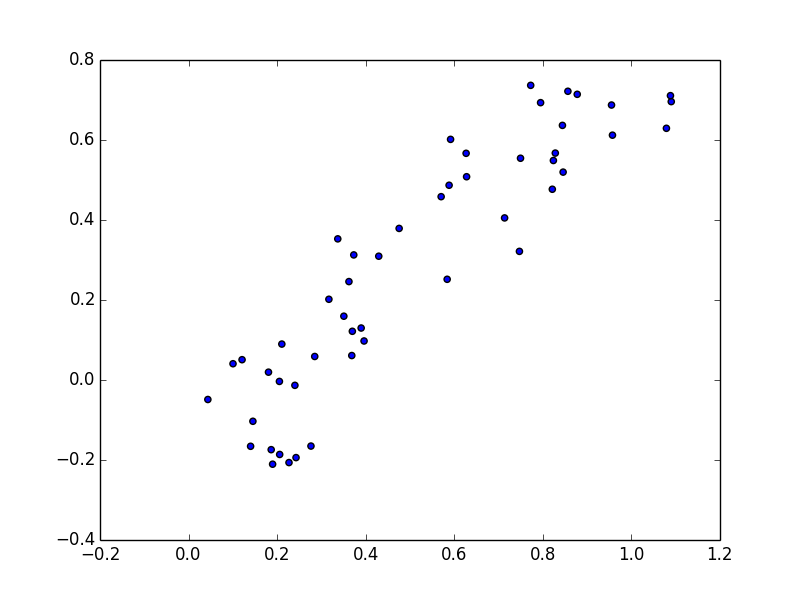

In [15]:
# for randomly generated W that gives z:
# calculate z, plot plot_1d_z vs y, calculate obj_val
num_trials = 10

def random_P():
    return kernels.ortho(np.random.uniform(low=-1.0,high=1.0,size=(x_dim,z_dim)))

for i in xrange(num_trials):
    rand_P = random_P()
    rand_zs = xs.dot(rand_P)

    rand_zs_obj_val = the_get_trace_from_P(rand_P)

    rand_plot_zs = rand_zs
    rand_plot_ys = ys
    rand_plot_1d_zs = rand_zs.dot(P_z)

    print 'trial', i
    print 'rand_P:', rand_P
    print 'dot with true_P:', rand_P.dot(P.T)

    print 'rand_zs_obj_val:', rand_zs_obj_val
    scatter(rand_plot_1d_zs,ys)

In [16]:
#
f_trace_P = functools.partial(kernels.get_trace_from_P, xs, ys, get_K, eps)
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
from pymanopt.manifolds import Stiefel
solver = pymanopt.solvers.SteepestDescent(logverbosity=2)
manifold = pymanopt.manifolds.Stiefel(x_dim, z_dim)
problem = pymanopt.Problem(manifold=manifold, cost=f_trace_P, verbosity=0)
P_fit, opt_log = solver.solve(problem)
print 'P_fit:', P_fit
print 'P_true:', P
print('And here comes the optlog:\n\r')
pp = pprint.PrettyPrinter()
pp.pprint(opt_log)

P_fit: [[-0.94663589]
 [-0.32230498]]
P_true: [[ 0.96337365]
 [-0.26816265]]
And here comes the optlog:

{'final_values': {'f(x)': 0.7682618258136148,
                  'gradnorm': 1.1137485769637831e-08,
                  'iterations': 14,
                  'stepsize': 5.0644839589673891e-08,
                  'time': 0.09157395362854004,
                  'x': array([[-0.94663589],
       [-0.32230498]])},
 'iterations': {'f(x)': [0.82482360062951088,
                         0.78558788369498267,
                         0.77026485801285238,
                         0.76940648231359587,
                         0.76864950529611353,
                         0.76856042547738856,
                         0.76830881278038232,
                         0.76826763100279016,
                         0.76826522986260093,
                         0.76826241074712098,
                         0.76826185009707193,
                         0.76826183058601782,
                         0.768261825

In [17]:
assert False

AssertionError: 